<h1>
<center>CFRM 421/5213</center>
</h1>

<h1>
<center>Yevgen Revtsov</center>
</h1>

<h1>
<center>Homework 3</center>
</h1>

* **Due: Tuesday, May 13, 2025, 11:59 PM**


* Total marks: 38


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Applying PCA [6 marks]

## (a) [4 marks]
Train a SVM classifier with a Gaussian RBF kernel on the MNIST training data (the first 60,000 observations). Use the default arguments for the classifier. Take the first 10,000 observations as the training set given by `X_train_red` and `y_train_red` in the code below. Time your training using `%time` and report the accuracy of the trained model on the test set (the last 10,000 observations of MNIST). Now, use PCA on the original training set (60,0000 observations) to find principal components with an explained variance ratio of 60%. Retrain the SVM classifier using these principal components instead of the original features. Time the training and accuracy on the test set. Comment on whether PCA helped or not. Do not shuffle the data and do not use a standard scaler.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
import numpy as np

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
mnist.target = mnist.target.astype(np.int8)
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]
X_train_red = mnist["data"][:10000]
y_train_red = mnist["target"][:10000]

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rbf = SVC(kernel="rbf")
%time rbf.fit(X_train, y_train)

CPU times: user 2min 8s, sys: 1.19 s, total: 2min 9s
Wall time: 2min 9s


SVC()

In [4]:
%time rbf.fit(X_train_red, y_train_red)

y_pred = rbf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

CPU times: user 3.35 s, sys: 44.3 ms, total: 3.39 s
Wall time: 3.4 s
Accuracy:  0.9594


In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(n_components=.6),
    SVC(kernel="rbf"),
)

%time clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

CPU times: user 3.7 s, sys: 241 ms, total: 3.94 s
Wall time: 3.89 s
Accuracy:  0.9723


PCA reduction seemed to help, raising the accuracy from 0.9594 to 0.9723. The runtime between the two models was comparable.

## (b) [2 marks]

Repeat (a) using a random forest classifier instead of the SVM classifier and comment on the result. Use `random_state=42` in the classifier and use the default for the other arguments. You are allowed to use `n_jobs=-1`.

In [6]:
# random forest on full training set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
%time rf.fit(X_train, y_train)

CPU times: user 24.7 s, sys: 355 ms, total: 25 s
Wall time: 2.3 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [7]:
# random forest on reduced training set

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
%time rf.fit(X_train_red, y_train_red)

y_pred = rf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

CPU times: user 3.06 s, sys: 54.9 ms, total: 3.11 s
Wall time: 330 ms
Accuracy:  0.95


In [8]:
# random forest of full training set after PCA

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(n_components=.6),
    RandomForestClassifier(random_state=42, n_jobs=-1),
)

%time clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

CPU times: user 25.4 s, sys: 373 ms, total: 25.8 s
Wall time: 2.74 s
Accuracy:  0.9444


PCA didn't really help when using random forest classifier. The CPU time is 10x that of the reduced training set model and the accuracy is the same.

# 2. Visualizing dimensionality reduction [8 marks]

## (a) [3 marks]
Load the MNIST dataset and take only the first 5,000 observations as `X` and `y`. Use the nonlinear dimensionality reduction technique **t-SNE** to reduce this subset of the MNIST dataset down to 2 dimensions. Include the argument `random_state=42`. Measure how long it took to reduce the dimensionality, this will be used in (b) below. Plot a scatterplot of the outcome of t-SNE. Use 10 different colors to represent each image's target class and plot scaled-down versions of the digit images themselves. The visualization will be too cluttered if you draw the image for every observation, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance. You should get a nice visualization of different classes and some of the digit images in them. See the textbook's Jupyter notebook for the code. Use the plot to comment on which classes are easily identified and which ones can be hard to distinguish.

Hint: See the solution of Chapter 8, Question 10 in this [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb) on the textbook website to see how to implement t-SNE and produce these plots using the `plot_digits()` function.

In [9]:
X = mnist["data"][:5000]
y = mnist["target"][:5000]

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
%time X_reduced = tsne.fit_transform(X)

CPU times: user 36.6 s, sys: 36.3 s, total: 1min 12s
Wall time: 6.12 s


In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

**[Add your solution here]**

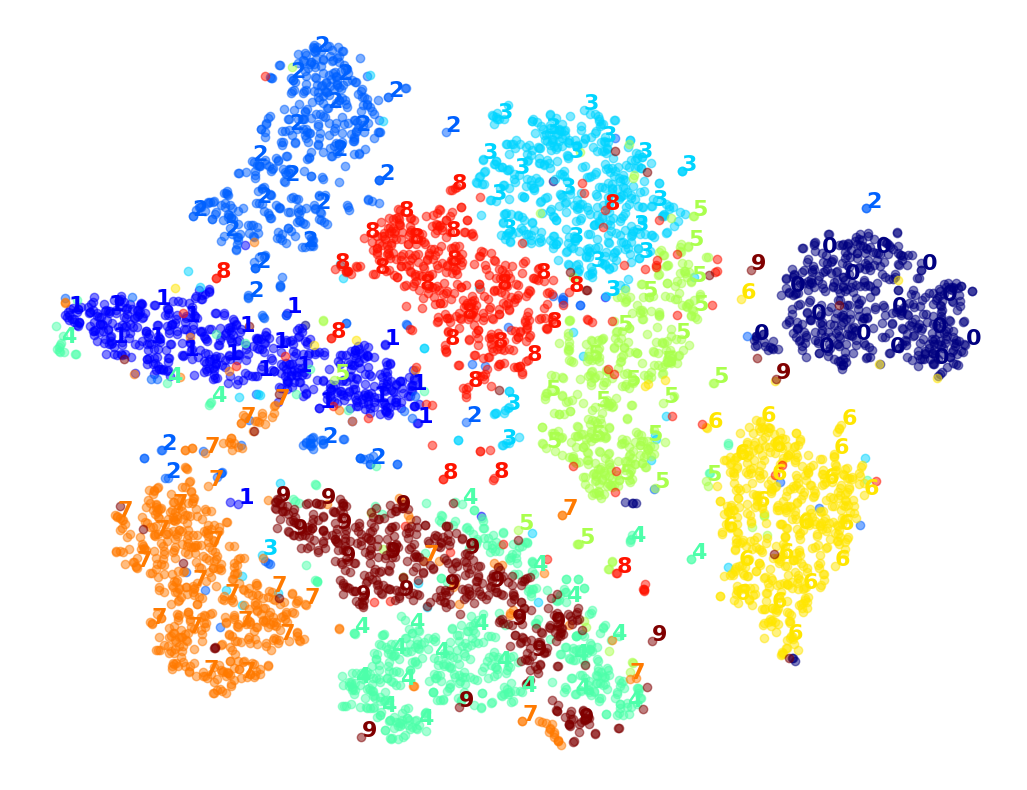

In [12]:
plot_digits(X_reduced, y)

Digits 7 and 9 are the hardest to separate, as they make a similar shape as the moons dataset. 3, 5, and 8 are also close together but separated enough. the rest of the digits are easily separated.

## (b) [5 marks]
Try using other dimensionality reduction methods. Specifically, try:

* Regular PCA to reduce to 2 dimensions.
* LLE to reduce to 2 dimensions.
* First apply PCA with an explained variance ratio of 95%, then apply t-SNE to reduce to 2 dimensions.

For each algorithm, include the argument `random_state=42`. Then for each of the three methods above, report how long it took to reduce the dimension. Also, provide a 2D plot of the results. Which method runs faster? Which one results in a better visualization? Include t-SNE from (a) as part of your comparison.

CPU times: user 22.5 ms, sys: 12 ms, total: 34.5 ms
Wall time: 28.8 ms


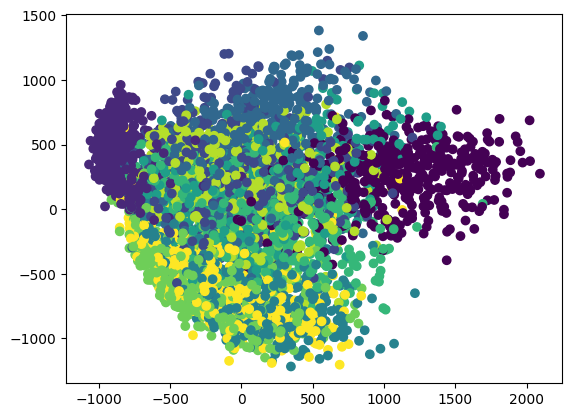

In [13]:
pca = PCA(n_components=2)
%time X_reduced_pca = pca.fit_transform(X)
# scatter plot of X_reduced_pca
plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, cmap='viridis')

CPU times: user 2.8 s, sys: 1.27 s, total: 4.07 s
Wall time: 692 ms


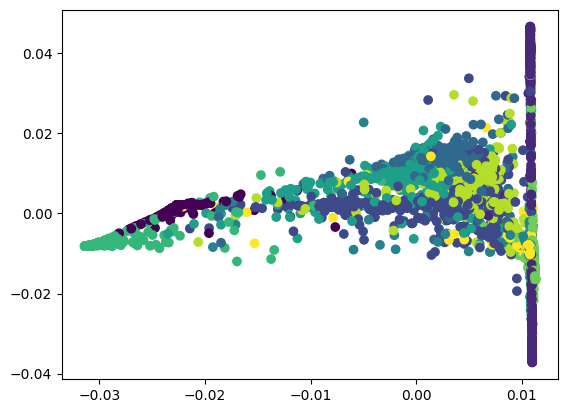

In [14]:
from sklearn.manifold import LocallyLinearEmbedding as LLE
# now use LLE instead
lle = LLE(n_components=2)
%time X_reduced_lle = lle.fit_transform(X)
# scatter plot of X_reduced_lle
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=y, cmap='viridis')


CPU times: user 165 ms, sys: 39.7 ms, total: 204 ms
Wall time: 146 ms
CPU times: user 36 s, sys: 37 s, total: 1min 12s
Wall time: 6.01 s


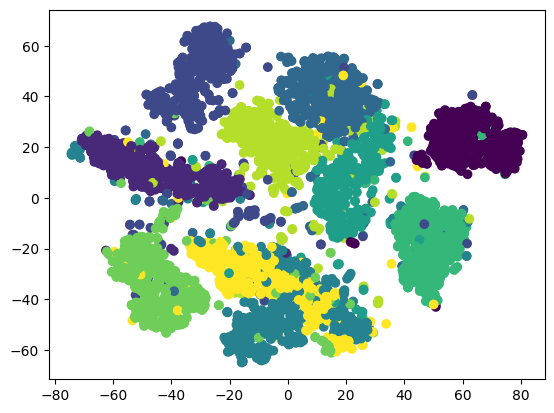

In [15]:
# apply PCA with an explained variance ratio of 95%, then apply t-SNE to reduce to 2 dimensions.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=0.95)
%time X_pca = pca.fit_transform(X)
tsne = TSNE(n_components=2, random_state=42)
%time X_tsne = tsne.fit_transform(X_pca)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.show()


PCA decomposition runs the fastest. However, t-SNE shows the best clustering of the data.

# 3. k-Means clustering [11 marks]

Hint: It is helpful to read the solution of Chapter 9, Question 10 and 11 in this [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb).

## (a) Chapter 9, Question 10 [6 marks]


The classic Olivetti faces dataset contains 400 grayscale $64\times 64$ pixel images of faces. Each image is flattened to a 1D vector of size 4096. 40 different people were photographed (10 times each), and the task is to train a model that can predict which person is represented in each picture. Load the dataset and split it into a training set and a validation set using the code below. Since the dataset is quite small, stratified sampling is used to ensure that there are the same number of images per person in each set. There is no need to create a test set.

In [16]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit

data = fetch_olivetti_faces()
# Creating validation set
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=120, random_state=42)
train_idx, val_idx = next(strat_split.split(data.data, data.target))
X_valid, y_valid = data.data[val_idx], data.target[val_idx]
# Creating training set
X_train, y_train = data.data[train_idx], data.target[train_idx]

Note that the dataset is already scaled between 0 and 1, so there is no need to use a standard scaler. Next, use PCA on the features with an explained variance ratio of 99%. Then cluster the images based on the reduced features using k-Means, where the argument `random_state=42` is included. To determine the number of clusters $k\in\{5,10,15,\dots,145\}$, (i) plot inertia, (ii) plot silhouette scores. Choose the number of clusters $k'$ based on (ii). Then (iii) plot silhouette diagrams where the number of clusters is 40 and $k'$, and explain which number of clusters is better. Finally, suppose we use $k'$ clusters, (iv) visualize the clusters by plotting the images in each cluster and comment on whether you see similar faces in each cluster.

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# apply PCA
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_train)

res = pd.DataFrame(columns=['inertia', 'silhouette'])
res.index.name = 'nclusters'
kmeans_per_k = dict()
for clus in np.arange(5, 146, 5):
    kmeans = KMeans(n_clusters=clus, random_state=42)
    kmeans.fit(X_pca)
    res.loc[clus] = [kmeans.inertia_, silhouette_score(X_pca, kmeans.labels_)]
    kmeans_per_k[clus] = kmeans

# plot intertia and silhouette scores for each, find the beest number of clusters (k')

# compare silhouette between 40 and k'

# plot images in each cluster, comment whether the faces are similar



### (i, ii): plot inertia and silhouette scores

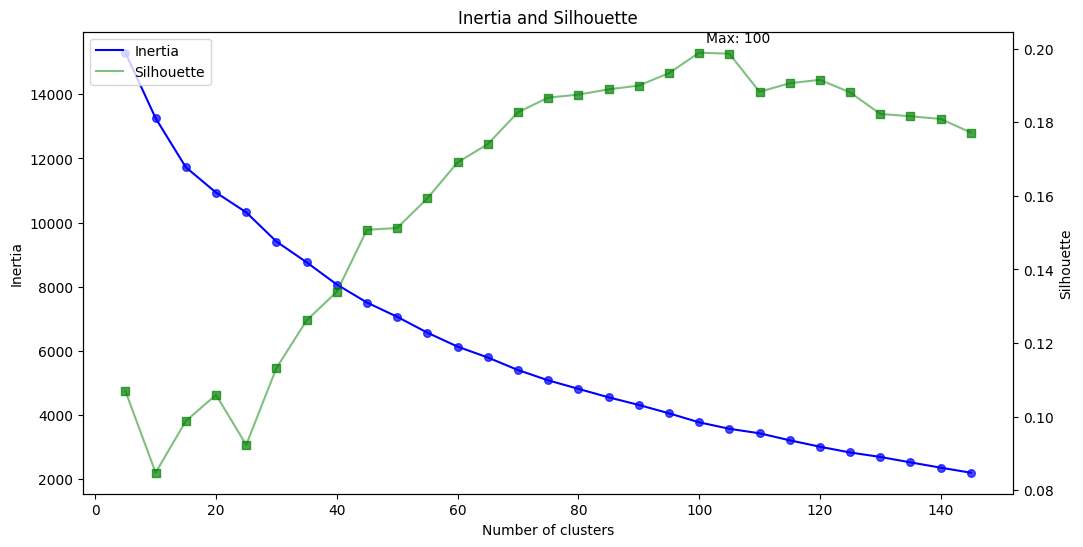

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()

res['inertia'].plot(ax=ax1, color='blue', label='Inertia')
res['silhouette'].plot(ax=ax2, color='green', label='Silhouette', alpha=0.5)

ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax2.set_ylabel('Silhouette')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Inertia and Silhouette')

# Add markers to each data point
ax1.scatter(res.index, res['inertia'], color='blue', marker='o', s=30, alpha=0.7)
ax2.scatter(res.index, res['silhouette'], color='green', marker='s', s=30, alpha=0.7)

# Find the index of the maximum silhouette score
max_silhouette_idx = res['silhouette'].idxmax()

# Add a text label for the maximum silhouette score
ax2.annotate(f'Max: {max_silhouette_idx}',
             xy=(max_silhouette_idx, res['silhouette'].max()),
             xytext=(5, 5),
             textcoords='offset points',
             ha='left',
             va='bottom')

plt.show()

Based on silhouette scores, using 100 clusters yields the highest score. This is of course a bit counterintuitive, since we know there are only 40 people and therefore ideally would be 40 clusters. It's interesting (but coincidental) that the inertial and silhouette lines cross at 40! Note: I'm plotting more than the requested 40 and 100 silhouette diagrams just to have some additinal context on the analysis. 

### (iii) silhouette diagrams

In [19]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(14, 12))

for i, k in enumerate((20, 40, 60, 80, 100, 120)):
    plt.subplot(3, 2, i + 1)

    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(X_pca, y_pred)

    padding = len(X_pca) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        if i % 10 == 0 or i == k - 1:
            ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(0, k + 1, 10)))

    plt.axvline(x=res.loc[k, 'silhouette'], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

### (iv):  plot images

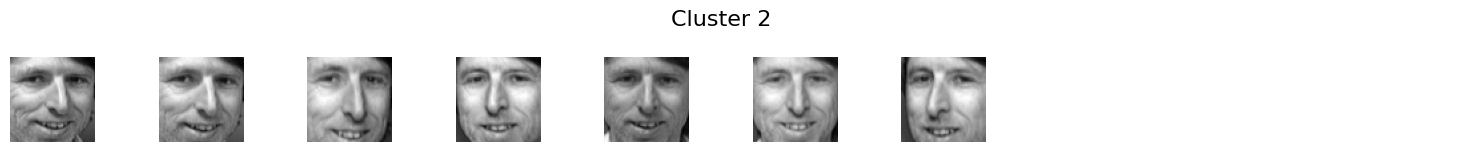

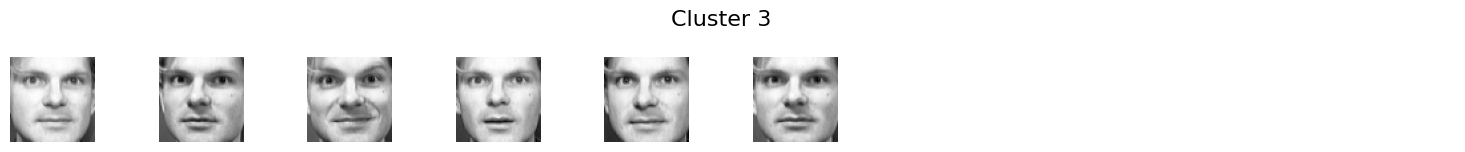

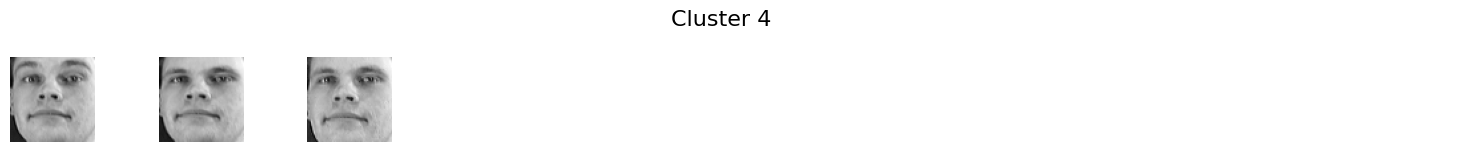

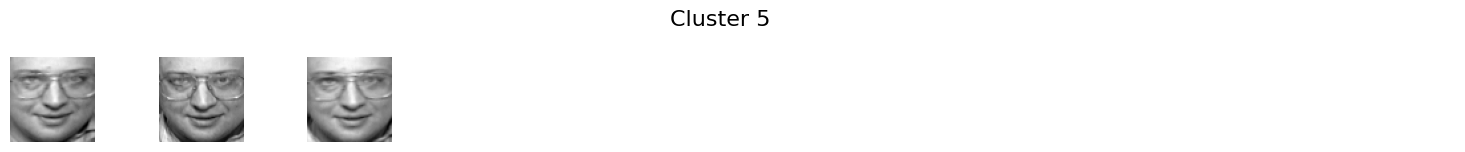

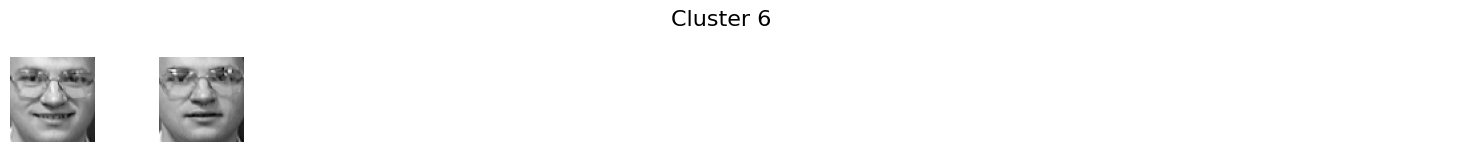

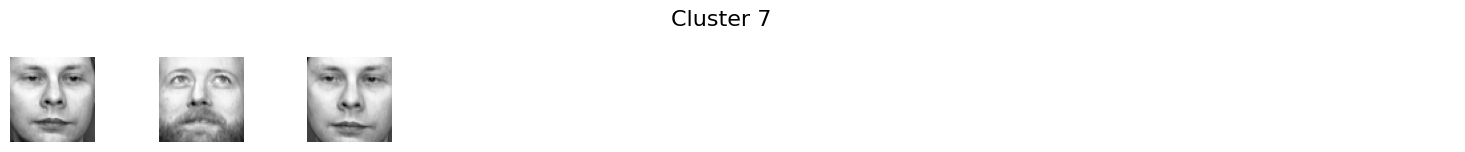

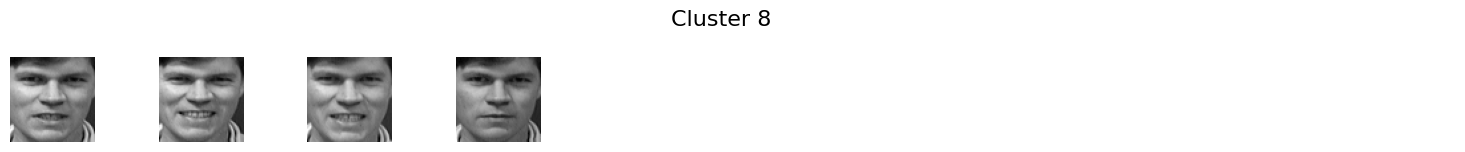

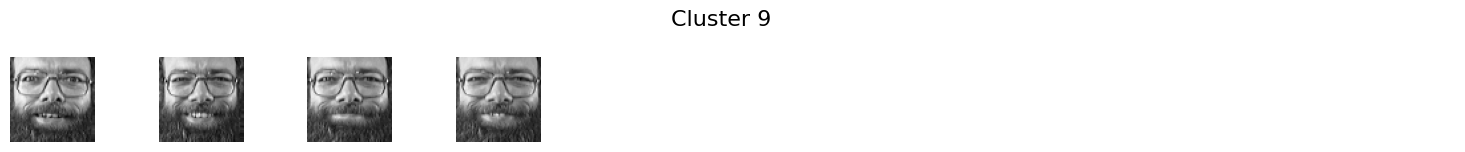

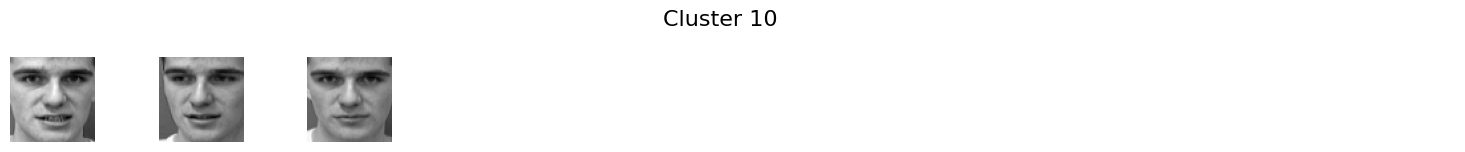

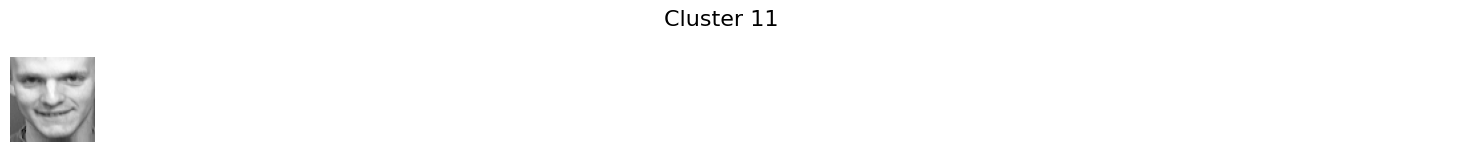

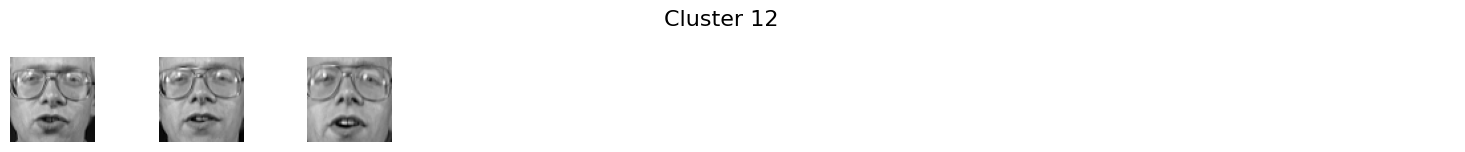

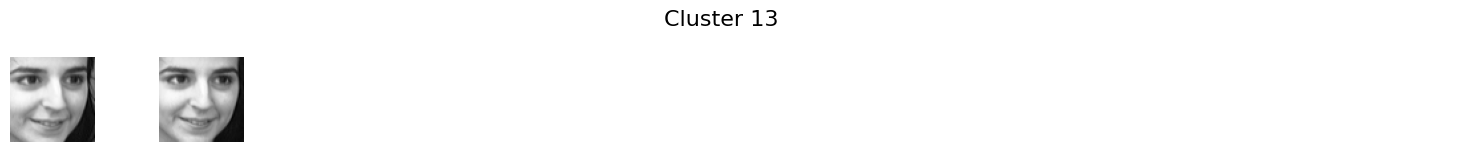

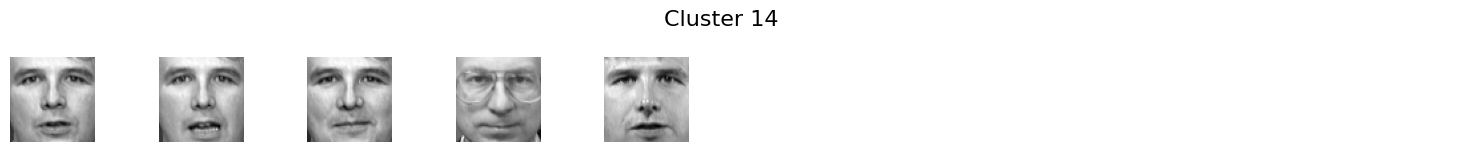

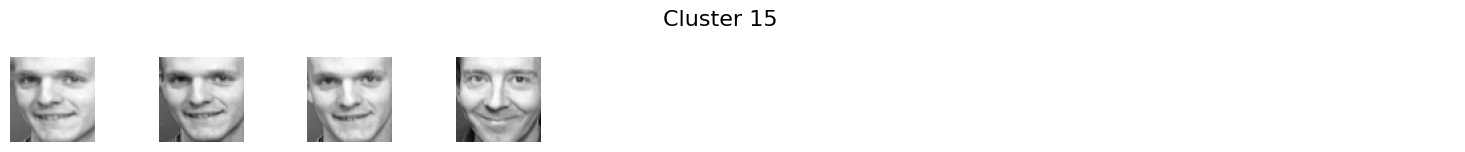

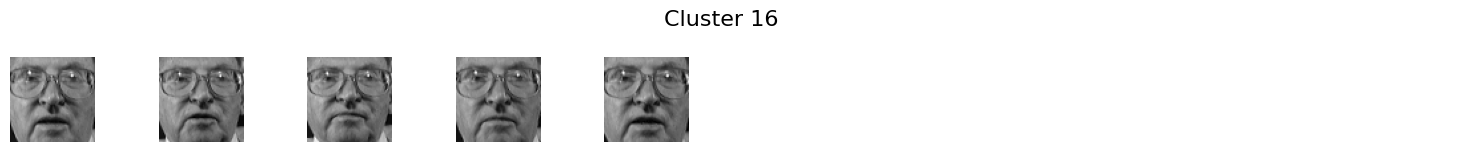

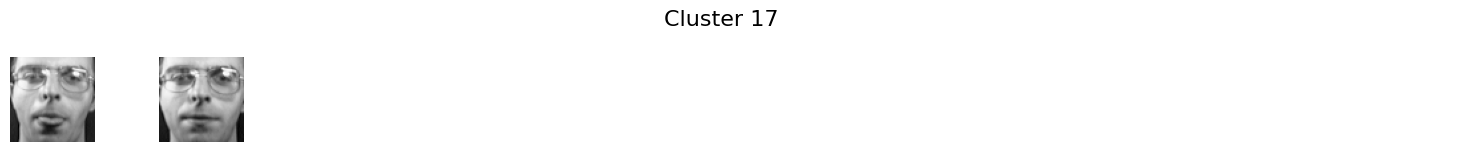

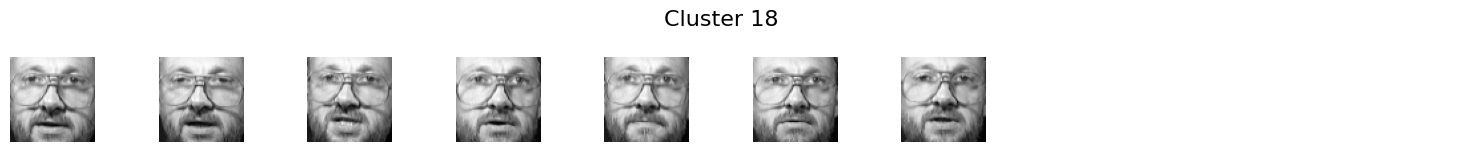

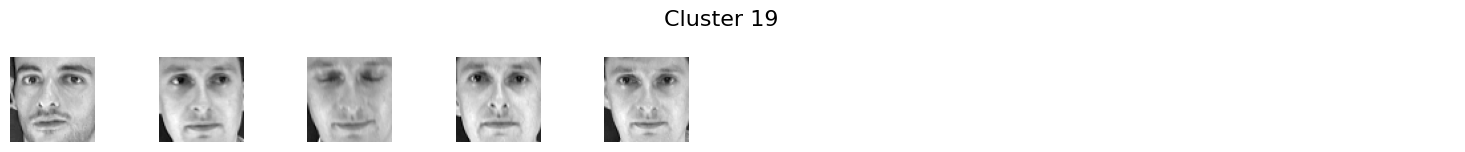

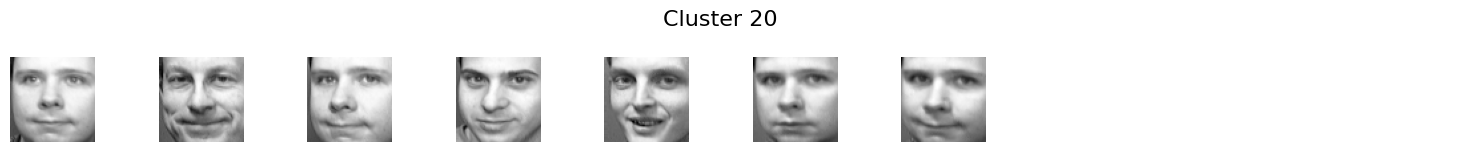

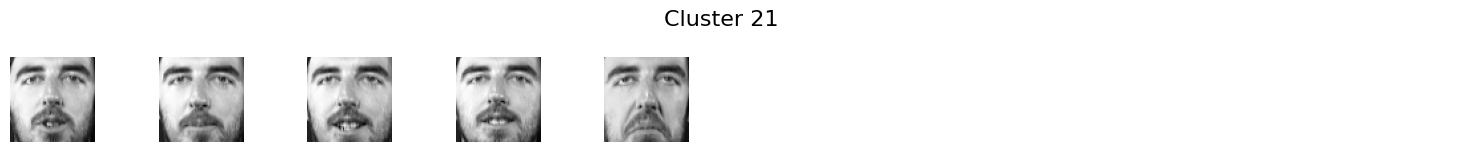

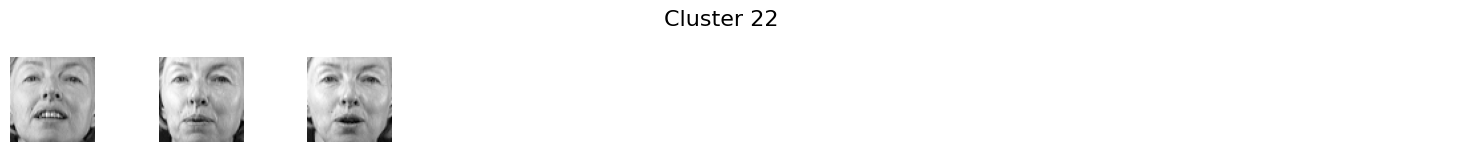

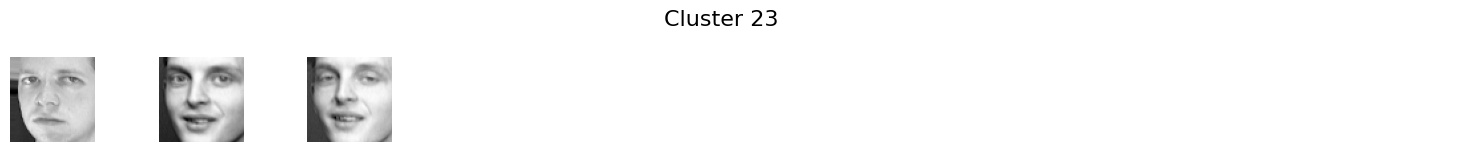

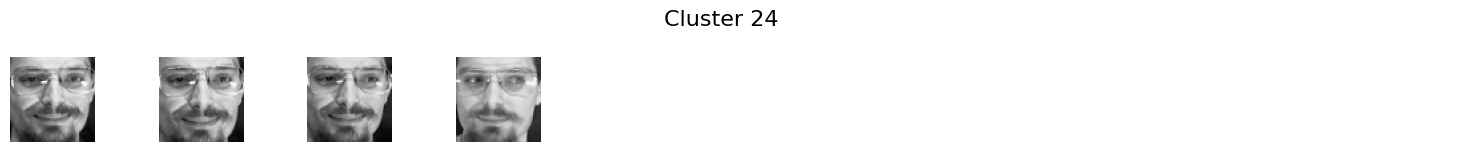

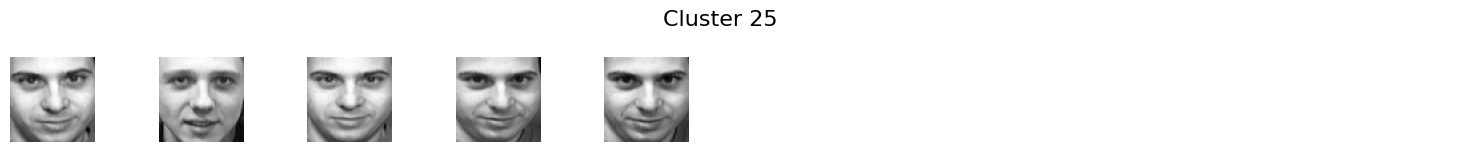

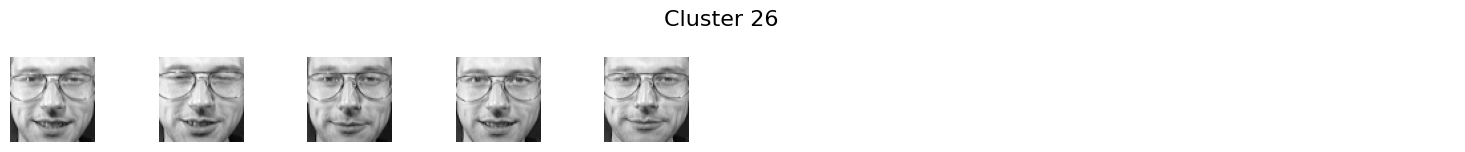

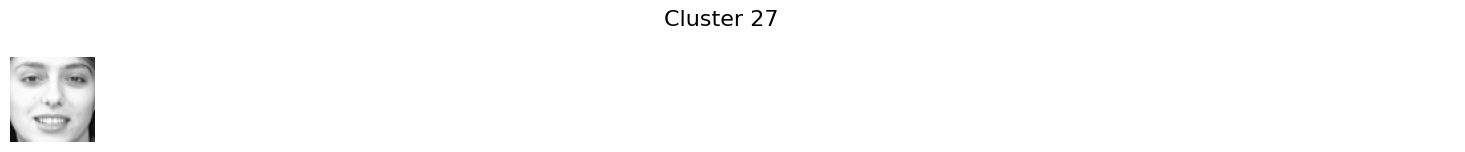

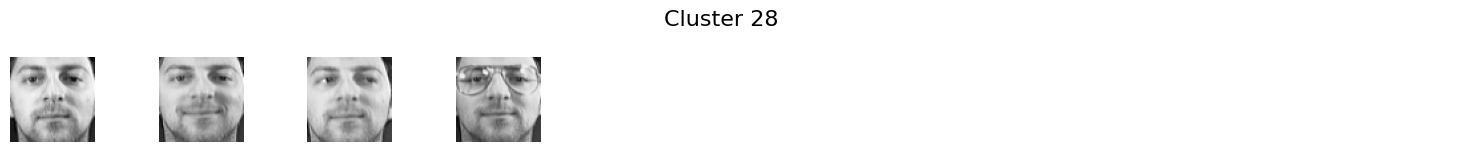

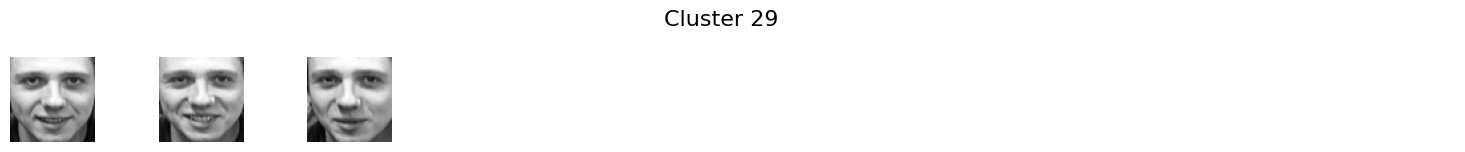

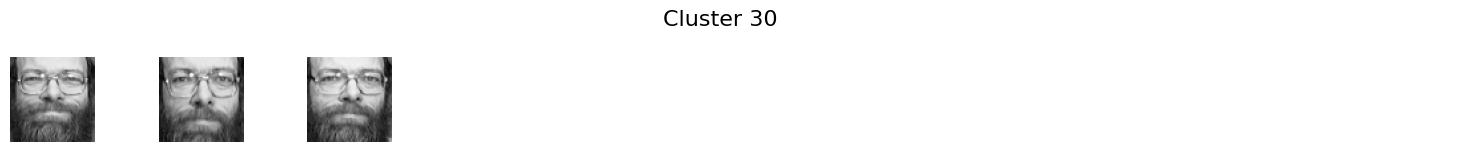

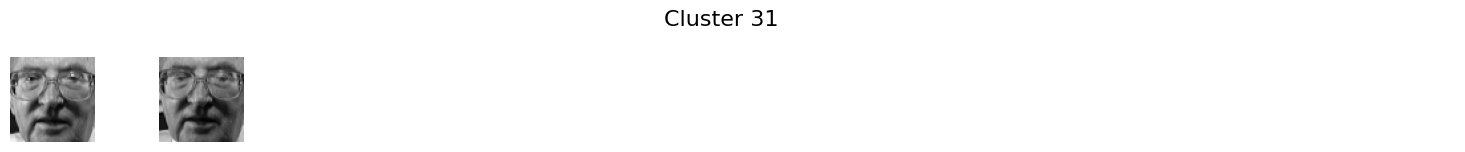

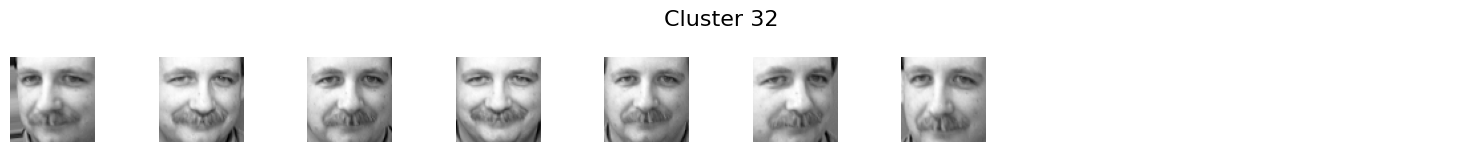

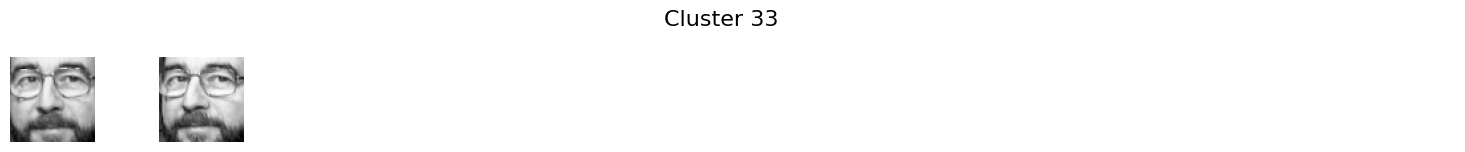

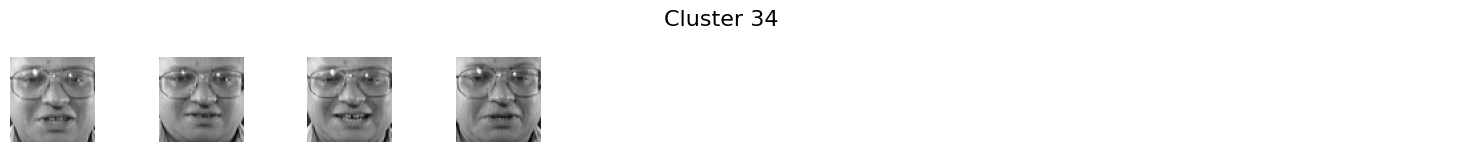

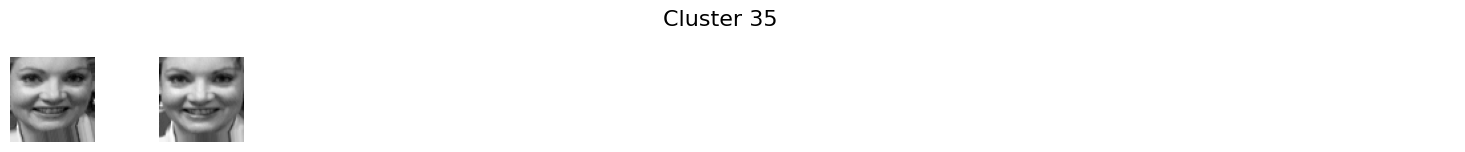

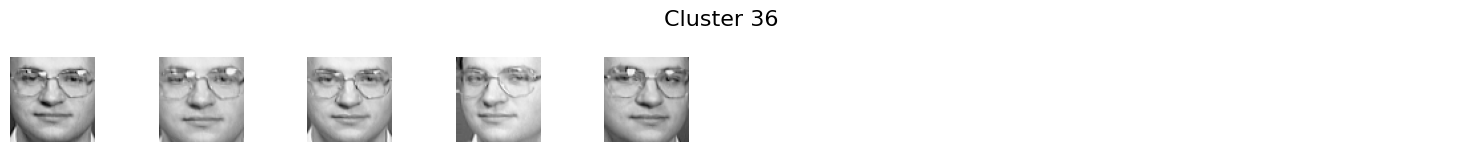

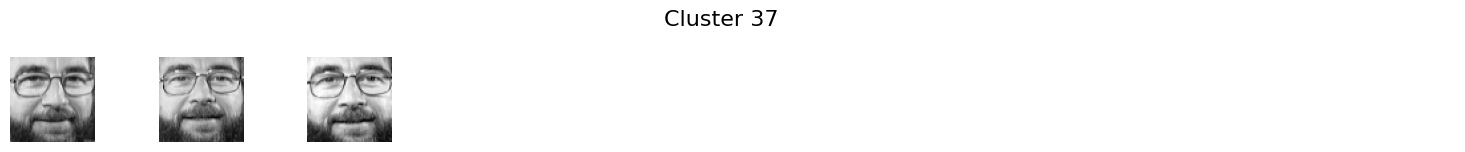

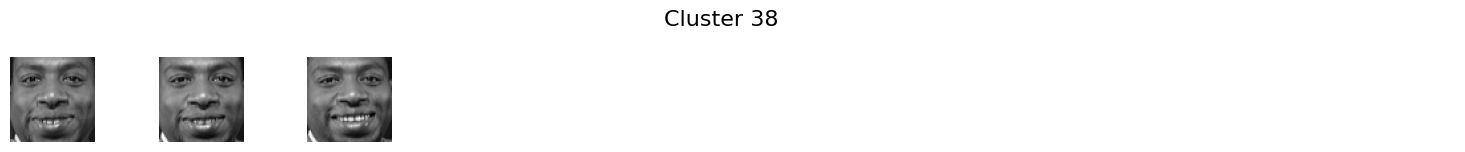

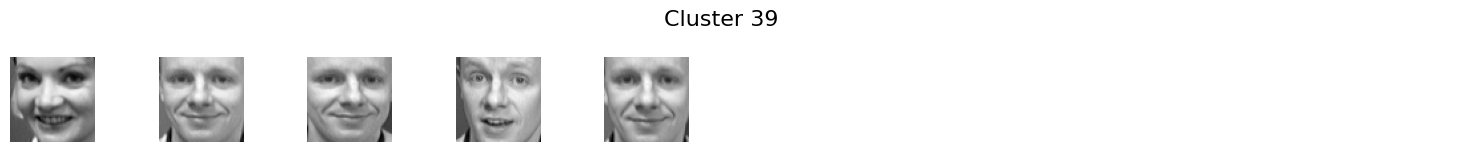

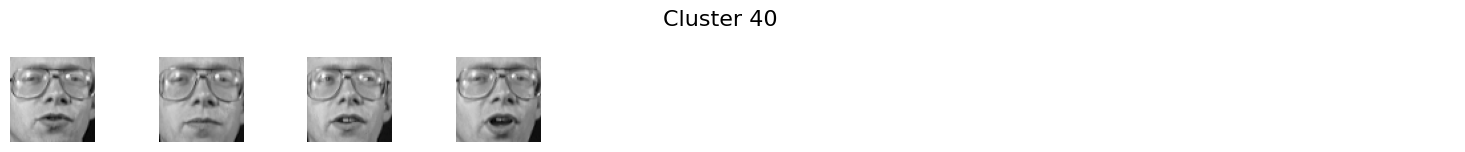

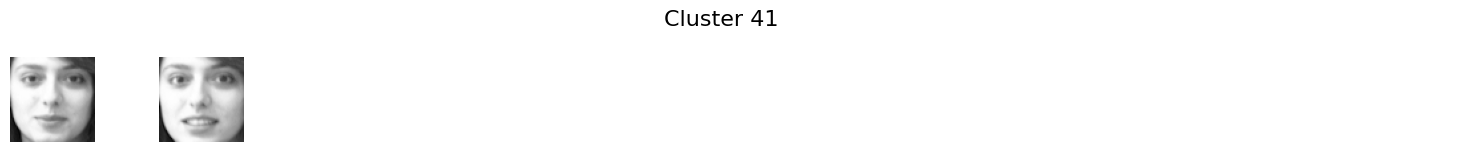

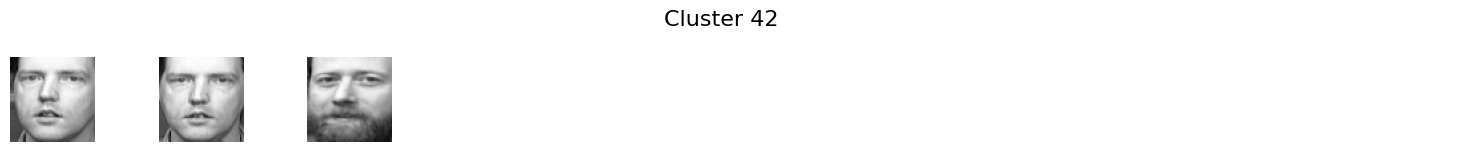

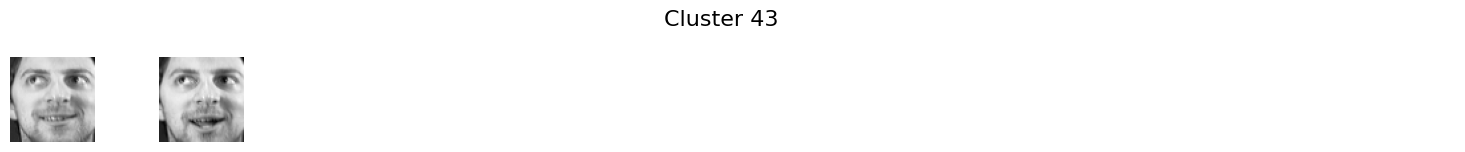

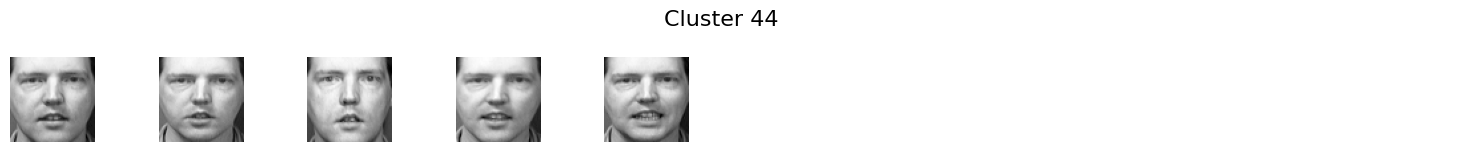

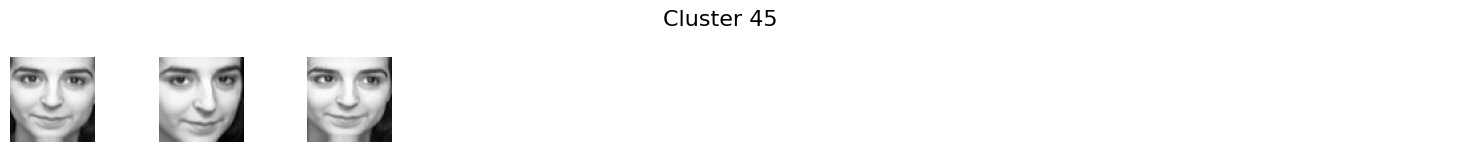

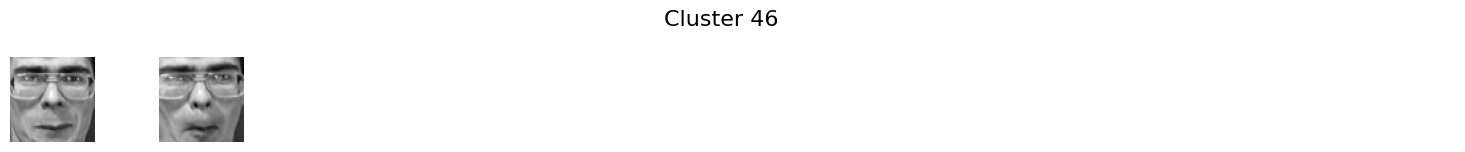

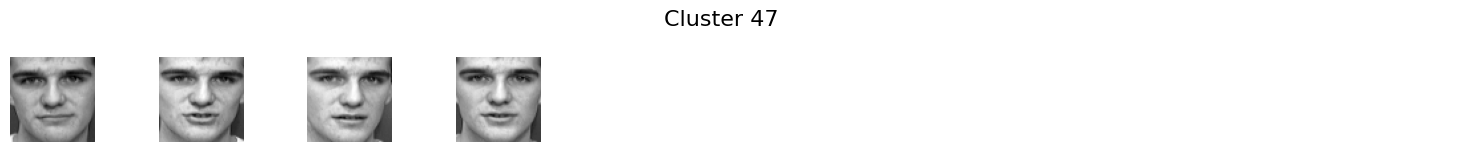

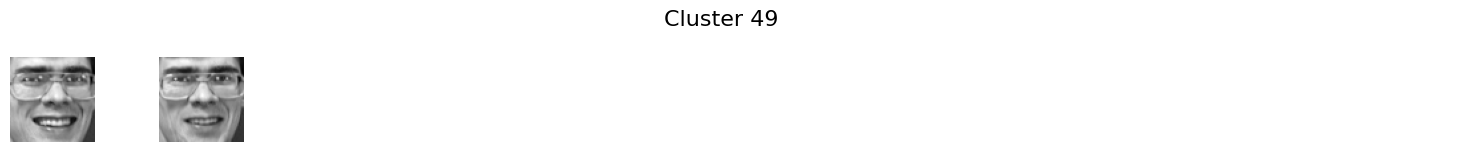

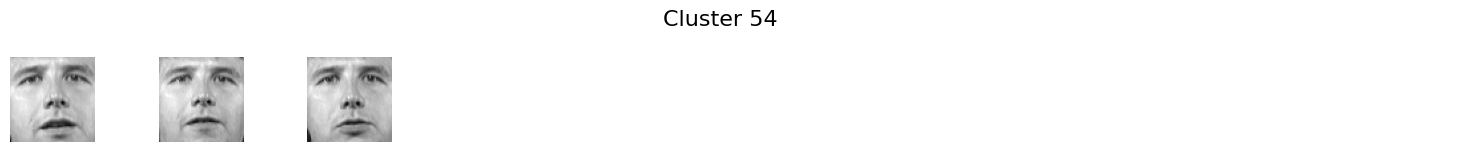

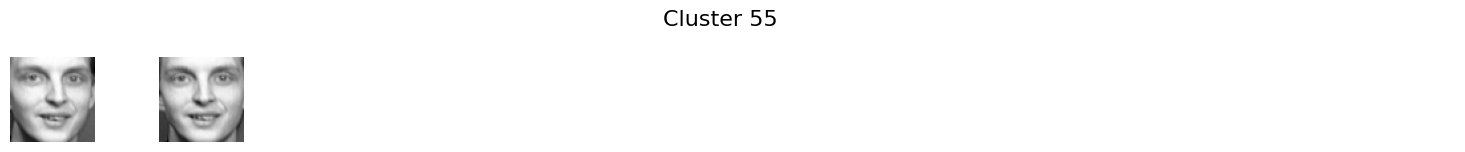

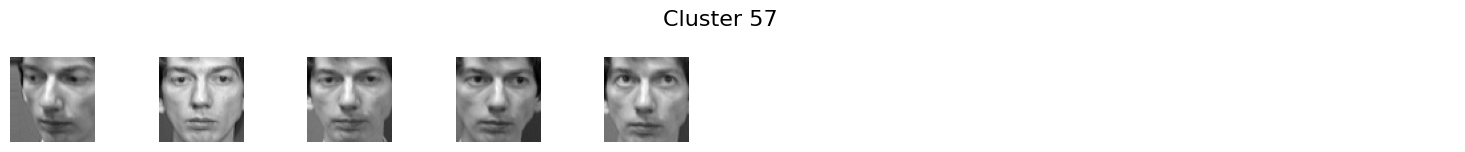

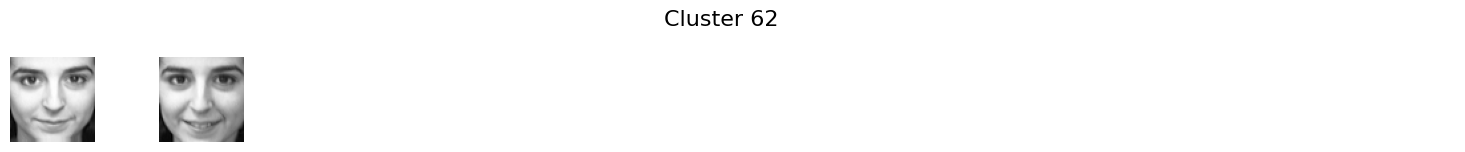

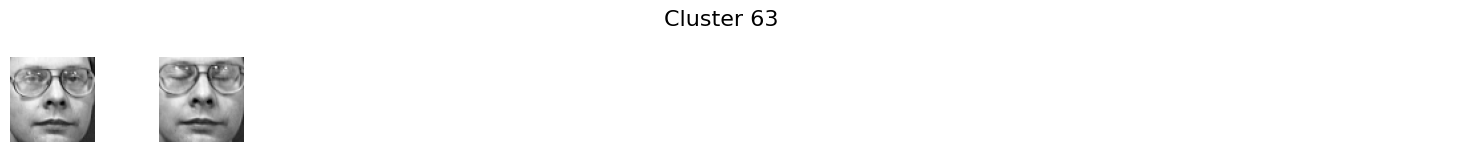

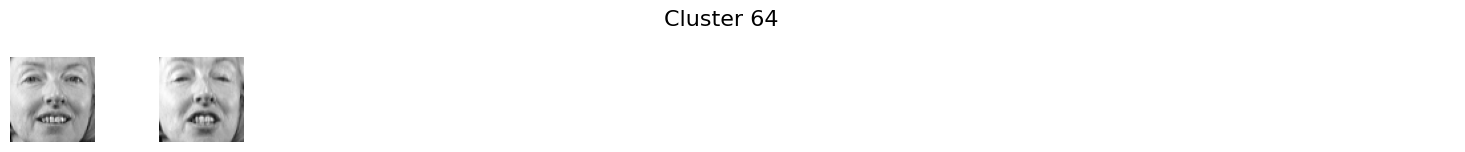

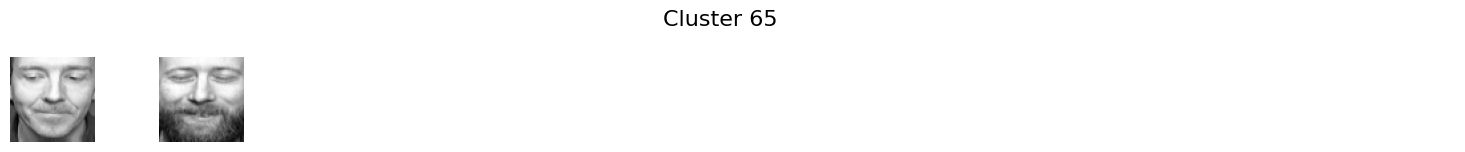

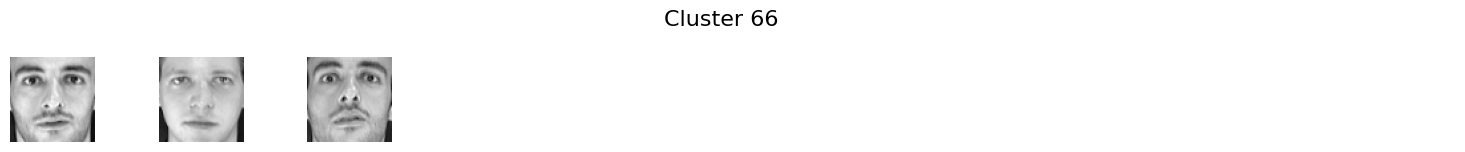

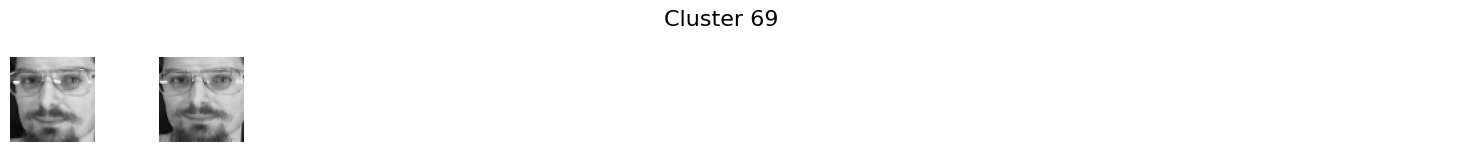

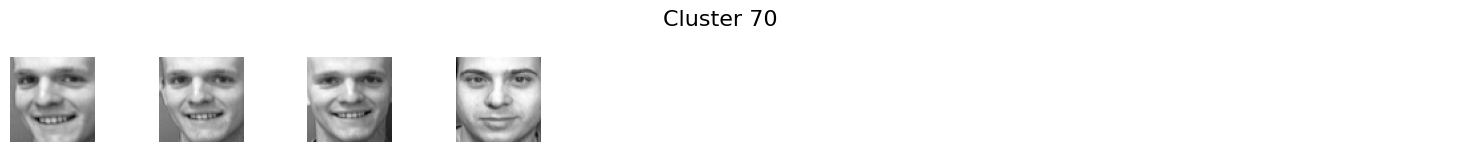

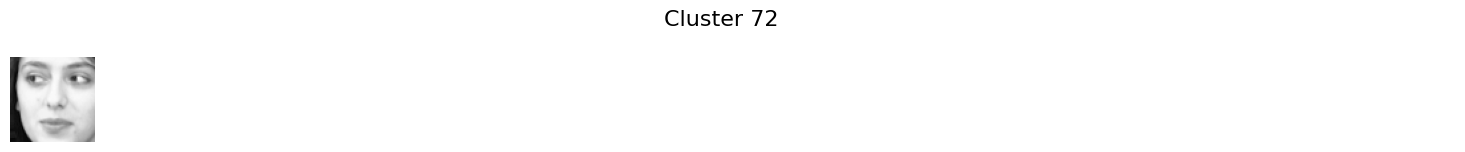

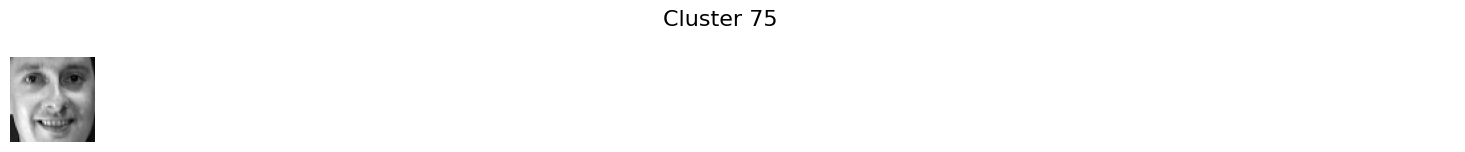

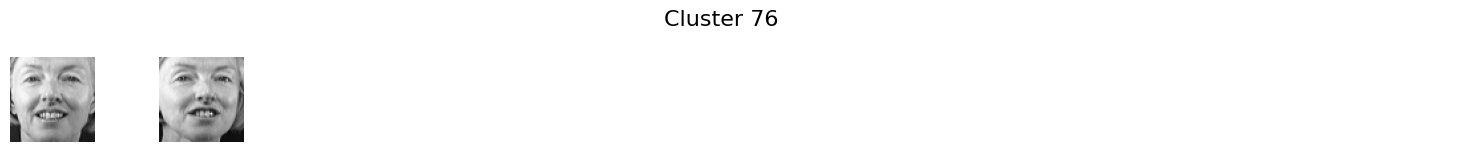

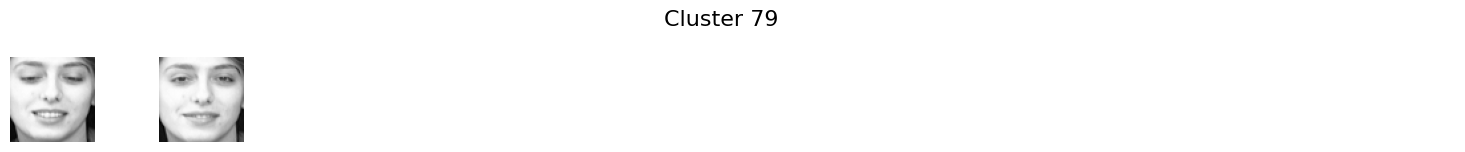

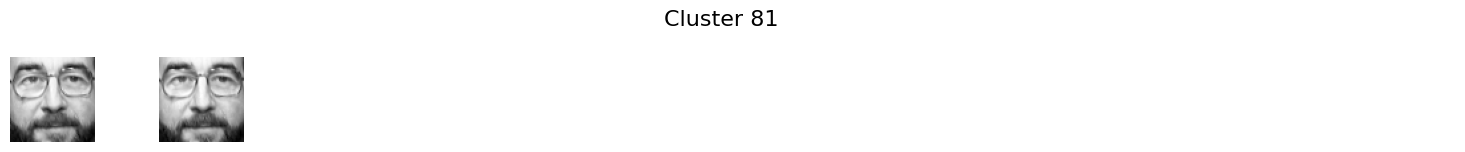

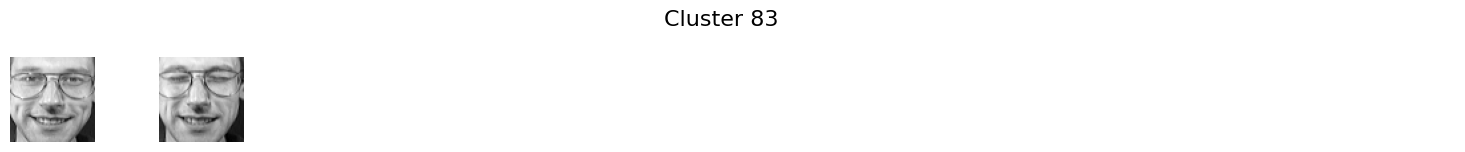

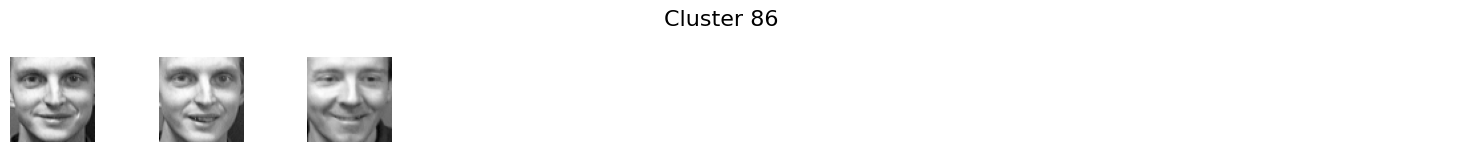

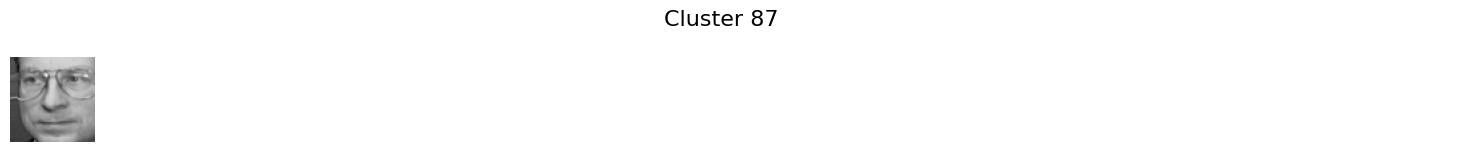

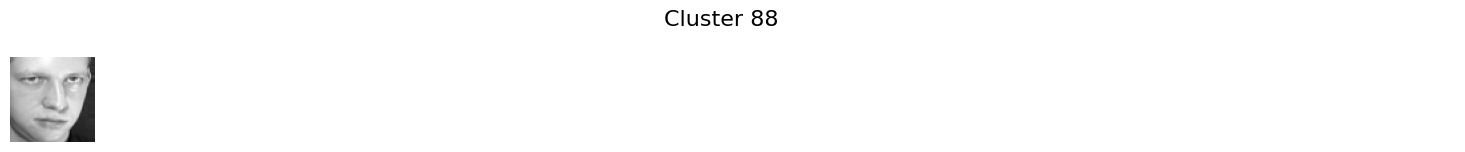

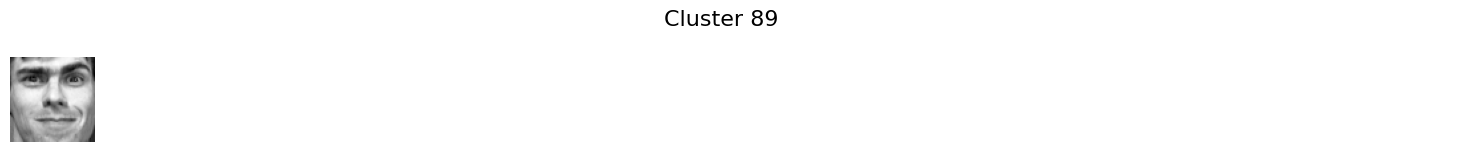

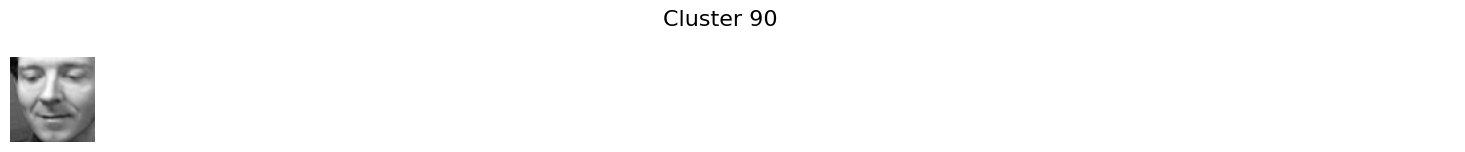

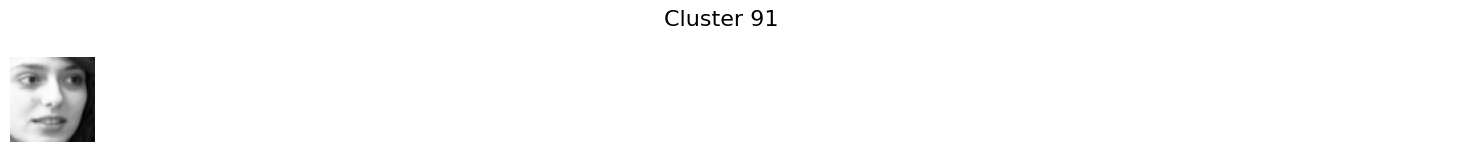

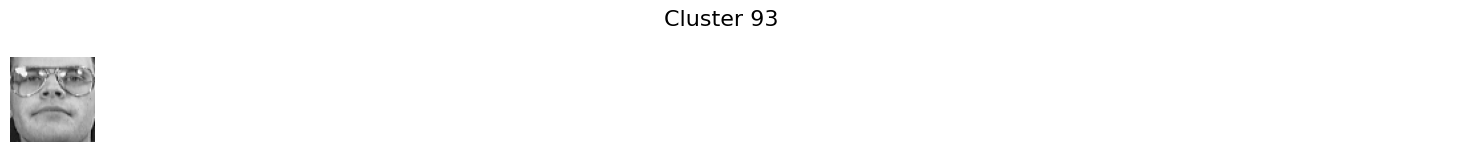

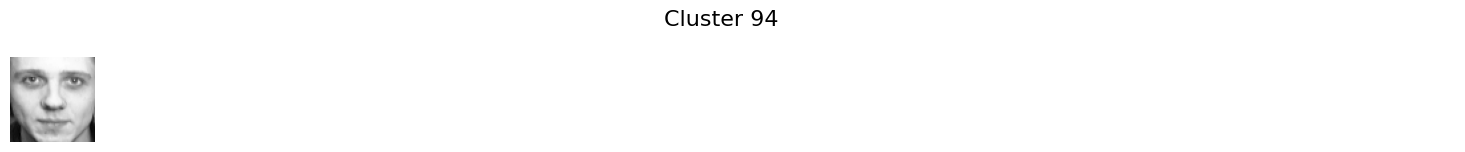

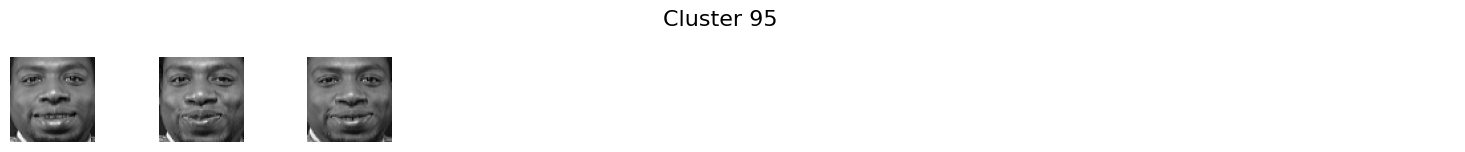

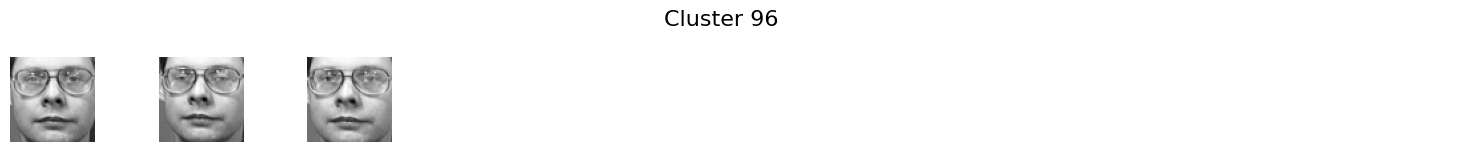

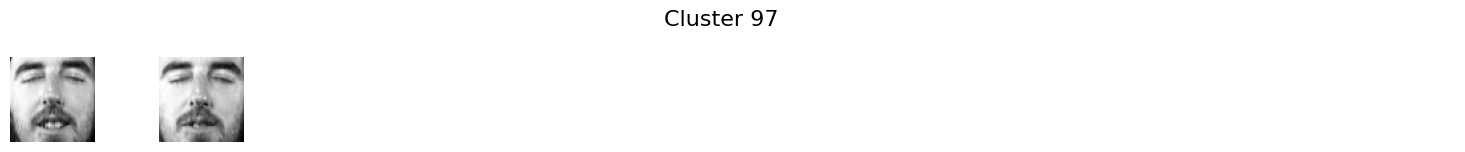

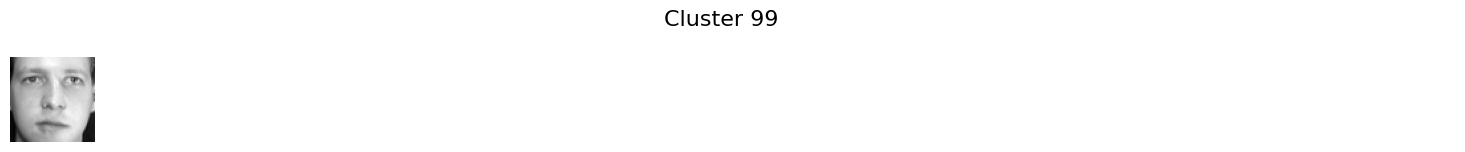

In [20]:
k_prime = 100
kmeans = kmeans_per_k[k_prime]
for clus in range(k_prime):  # Iterate through clusters 0 to 10
    indexes = np.where(kmeans.labels_ == clus)
    n_cols = 10
    n_rows = (len(indexes[0]) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5*n_cols, 1.5*n_rows))
    fig.suptitle(f'Cluster {clus}', fontsize=16)
    axes = axes.flatten()

    for i, idx in enumerate(indexes[0]):
        if i < len(axes):
            axes[i].imshow(X_train[idx].reshape(64, 64), cmap='gray')
            axes[i].axis('off')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Plotting the 100 clusters as requested. I definitely see similar images in each cluster, but we know there are only 40 different people. Facial expressions, different lighting are amongst the variables that can impact an image to be classified to a different cluster.

## (b) [2 marks]

Continue to use the reduced features based on PCA in (a). Train a random forest classifier `RandomForestClassifier(n_estimators=150, random_state=42)` and a histogram-based gradient boosting classifier using `HistGradientBoostingClassifier(max_iter=200, random_state=42, early_stopping=True, validation_fraction=0.2)` to predict which person is represented in each picture, and evaluate it on the validation set. For the gradient boosting classifier state the optimal number of iterations from early stopping. State which of the two models is better.

In [21]:
# Continue to use the reduced features based on PCA in (a). Train a random forest classifier `RandomForestClassifier(n_estimators=150, random_state=42)` and a histogram-based gradient boosting classifier using `HistGradientBoostingClassifier(max_iter=200, random_state=42, early_stopping=True, validation_fraction=0.2)` to predict which person is represented in each picture, and evaluate it on the validation set. For the gradient boosting classifier state the optimal number of iterations from early stopping. State which of the two models is better.
# TODO!!!

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

rf_pipe = Pipeline([
    ('pca', PCA(n_components=.99)),
    ('rf', RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1))
])
gb_pipe = Pipeline([
    ('pca', PCA(n_components=.99)),
    ('gb', HistGradientBoostingClassifier(max_iter=200, random_state=42, early_stopping=True, validation_fraction=0.2))
])



rf_pipe.fit(X_train, y_train)
gb_pipe.fit(X_train, y_train)

y_pred_rf = rf_pipe.predict(X_valid)
y_pred_gb = gb_pipe.predict(X_valid)

print("Random Forest accuracy: ", accuracy_score(y_valid, y_pred_rf))
print("Gradient Boosting accuracy: ", accuracy_score(y_valid, y_pred_gb))

n_iterations = gb_pipe.named_steps['gb'].n_iter_
print("Number of GB iterations: ", n_iterations)

Random Forest accuracy:  0.9333333333333333
Gradient Boosting accuracy:  0.7666666666666667
Number of GB iterations:  85


Random forest is more accurate at predicting than gradient boosting with 93% accuracy vs 77%. Gradient boosting stopped after 85 iterations.

## (c) Chapter 9, Question 11 [4 marks]

Continuing on from (b), regardless of which model is better, use the random forest classifier. Next, use k-Means as a dimensionality reduction tool, and train a classifier. Search for the number of clusters $k\in\{5,10,15,\dots,145\}$ that allows the classifier to get the best performance on the validation set. What performance can you reach on the validation set? What if you append the features from the reduced set to the original features and again search for the best number of clusters?

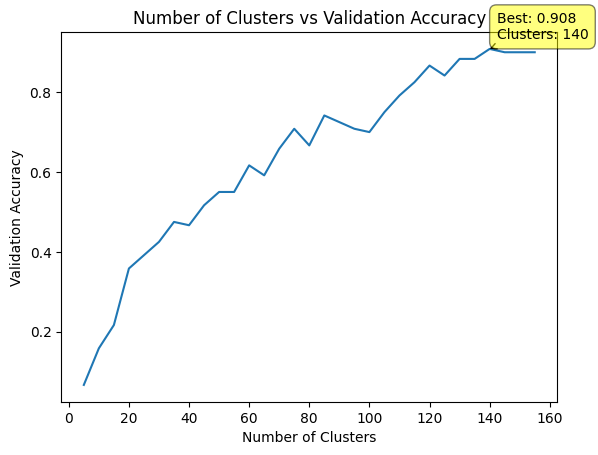

In [22]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def get_representative_images(X, kmeans):
    distances = kmeans.transform(X)
    return X[np.argmin(distances, axis=0)]

scores = []
cluster_range = range(5, 156, 5)

for n_clusters in cluster_range:
    # run kmeans on train data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train)
    
    # get "representative" images - image closer to each centroid
    representative_images = get_representative_images(X_train, kmeans)
    # look up the labels of these images in y_train
    representative_labels = y_train[np.argmin(kmeans.transform(X_train), axis=0)]

    # fit this subset using random forest
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=150)
    rf.fit(representative_images, representative_labels)
    # calculate the score on validation data
    y_pred = rf.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    scores.append(score)

plt.plot(cluster_range, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Validation Accuracy')
plt.title('Number of Clusters vs Validation Accuracy')
max_score = max(scores)
max_index = scores.index(max_score)
best_n_clusters = cluster_range[max_index]
plt.annotate(f'Best: {max_score:.3f}\nClusters: {best_n_clusters}',
             xy=(best_n_clusters, max_score),
             xytext=(5, 5),
             textcoords='offset points',
             ha='left',
             va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.show()



The best accuracy score is 90.8% using 140 clusters. Trying to use more clusters actually lowers the accuracy to 90% and seems to plateau there.

# 4. Finding regimes in time series [12 marks]

## (a) [6 marks]
Obtain the daily values of the CPI and unemployment rate from FRED up to 2023-01-01 and then convert the CPI into the yearly inflation rate `inf_data` using the following code. Note that you may have to install the package `pandas_datareader`. Alternatively, you can download the data as a csv file from [Canvas](https://canvas.uw.edu/files/105781273/download?download_frd=1).

In [23]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

unemp_data = pdr.get_data_fred('UNRATE', datetime(1945,1,1),datetime(2023,1,1))
cpi_data = pdr.get_data_fred('CPIAUCSL', datetime(1945,1,1),datetime(2023,1,1))
inf_data = (cpi_data/cpi_data.shift(12)-1).iloc[12:]
data = pd.concat([inf_data, unemp_data],axis=1)


In [24]:
data.sample(5)

CPIAUCSL  UNRATE
DATE                        
2001-05-01  0.035631     4.3
2013-05-01  0.013904     7.5
2015-10-01  0.001276     5.0
1978-11-01  0.088710     5.9
1967-05-01  0.023184     3.8

Split the data into a training set (before Jan 2005, using `data[:"2005-1-1"]` for instance) and a test set (Jan 2005 and after). Now, ignore the time aspect of your training set by treating it as a 2-dimensional dataset. Use k-means to divide your training set into a number of clusters called **regimes**. To find the number of regimes (clusters) $k\in\{2,3,\dots,10\}$: (i) plot inertia, (ii) plot silhouette scores, (iii) plot silhouette diagrams for $k\in\{2,3,\dots,10\}$. How many regimes do you choose? Explain your answer. Recall that you should use a standard scaler before applying k-means.

In [25]:
X_train = data.loc[:'2005-1-1', :]
X_test = data.loc['2005-1-1':, :]

clus_options = np.arange(2, 11)

In [26]:
res = pd.DataFrame(columns=['inertia', 'silhouette'])
res.index.name = 'nclusters'
kmeans_per_k = dict()

X_train_norm = StandardScaler().fit_transform(X_train)

for clus in clus_options:
    kmeans = KMeans(n_clusters=clus, random_state=42)
    kmeans.fit(X_train_norm)
    res.loc[clus] = [kmeans.inertia_, silhouette_score(X_train_norm, kmeans.labels_)]
    kmeans_per_k[clus] = kmeans

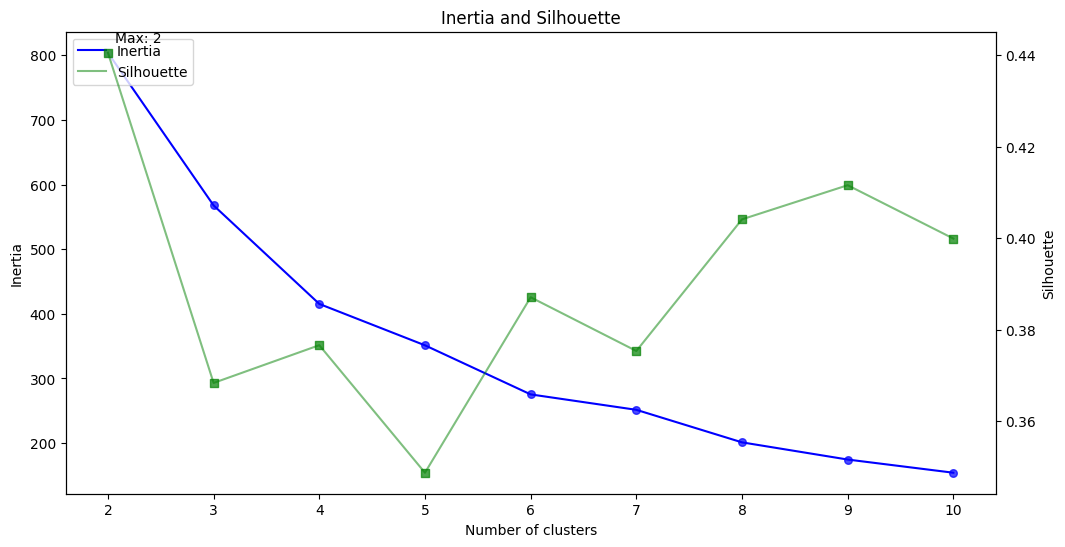

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()

res['inertia'].plot(ax=ax1, color='blue', label='Inertia')
res['silhouette'].plot(ax=ax2, color='green', label='Silhouette', alpha=0.5)

ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax2.set_ylabel('Silhouette')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Inertia and Silhouette')

# Add markers to each data point
ax1.scatter(res.index, res['inertia'], color='blue', marker='o', s=30, alpha=0.7)
ax2.scatter(res.index, res['silhouette'], color='green', marker='s', s=30, alpha=0.7)

# Find the index of the maximum silhouette score
max_silhouette_idx = res['silhouette'].idxmax()

# Add a text label for the maximum silhouette score
ax2.annotate(f'Max: {max_silhouette_idx}',
             xy=(max_silhouette_idx, res['silhouette'].max()),
             xytext=(5, 5),
             textcoords='offset points',
             ha='left',
             va='bottom')

plt.show()

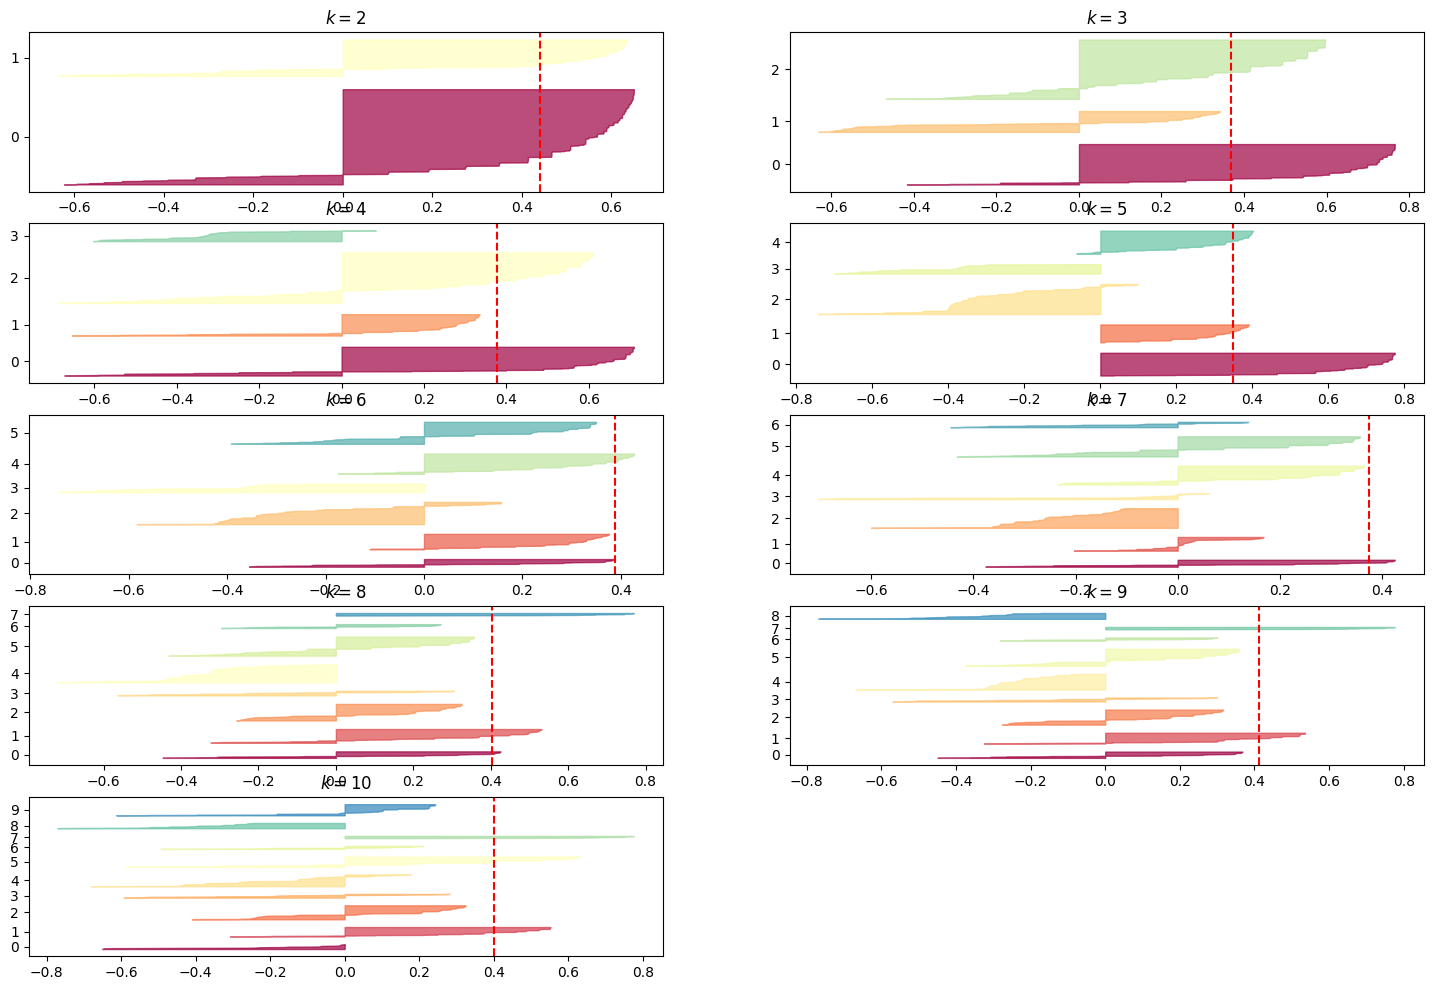

In [28]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(18, 12))

for i, k in enumerate(clus_options):
    plt.subplot(int(np.ceil(len(clus_options) / 2)), 2, i + 1)

    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X_train) // 10
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    plt.axvline(x=res.loc[k, 'silhouette'], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

It's pretty clear the dataset has some outliers regardless of choise of number of clusters. Intiutively - this is financial data and if it was easy to classify it, it would be easy to prodict and therefore profit off the prediction. So it's expected that the classification is not straigtforward.

But between the highest silhouette score and revieing the silhouette diagrams, the best number of clusters is 2. It's the highest overall silhouette score and the only one that shows clear separation of clusters via silhouette diagram.

## (b) [3 marks]

Report the centroid of the regimes in (a). For the training set, plot the inflation rate (x-axis) vs unemployment rate (y-axis) after these features have been standardized, and show the regimes and centroids in the plot. For the test set, plot time series of the inflation rate and unemployment rate (the original series before standardization), and show the regimes on the plot. The regimes can be shown using time series (line graphs) of the centroid for each of two series for instance, and the following code can be used, where `best_mod_pred` is the prediction on the test set from the best model.

In [29]:
# kmeans with 2 clusters
best_kmeans = kmeans_per_k[2]
best_kmeans.cluster_centers_

array([[-0.36733388, -0.42687218],
       [ 0.95700143,  1.11211437]])

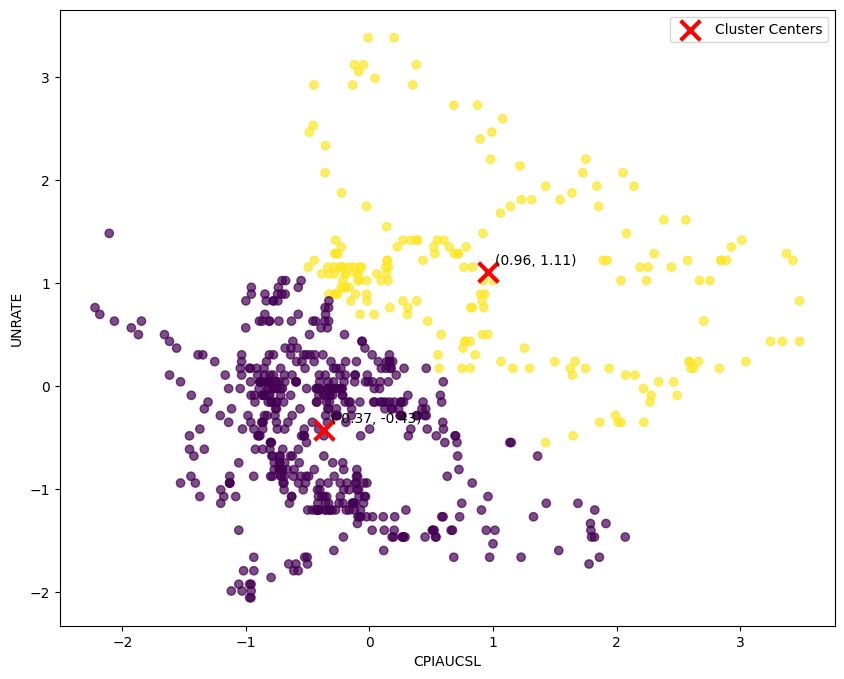

In [30]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=best_kmeans.labels_, cmap='viridis', alpha=0.7)
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.xlabel('CPIAUCSL')
plt.ylabel('UNRATE')
for center in best_kmeans.cluster_centers_:
    plt.annotate(f'({center[0]:.2f}, {center[1]:.2f})',
                 (center[0], center[1]),
                 xytext=(5, 5),
                 textcoords='offset points')

plt.legend()
plt.show()


In [31]:
data_test = X_test.copy()
best_mod_pred = best_kmeans.predict(StandardScaler().fit_transform(X_test.values))
data_test['regime'] = best_mod_pred

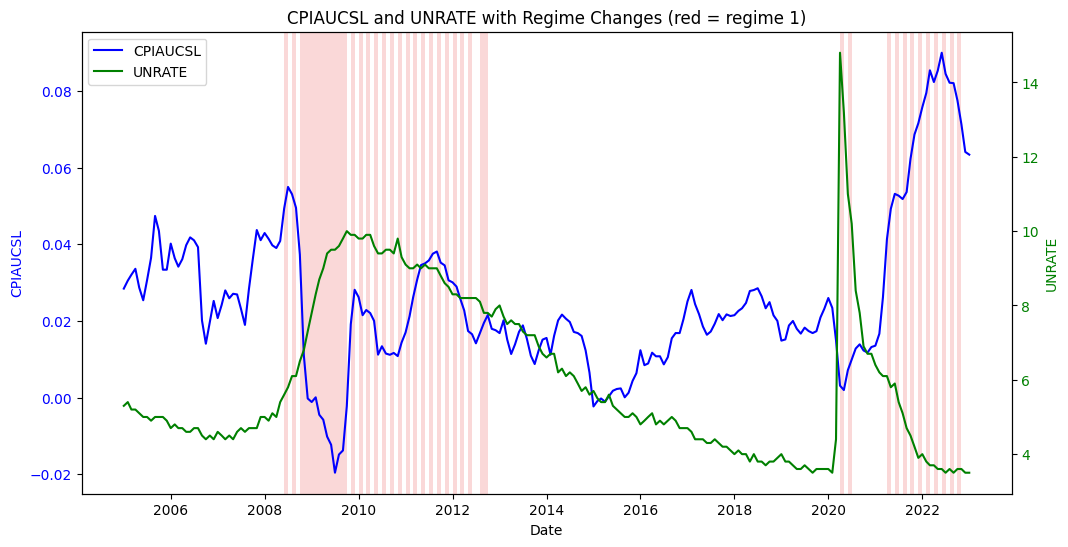

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CPIAUCSL
ax1.plot(data_test.index, data_test['CPIAUCSL'], color='blue', label='CPIAUCSL')
ax1.set_xlabel('Date')
ax1.set_ylabel('CPIAUCSL', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for UNRATE
ax2 = ax1.twinx()
ax2.plot(data_test.index, data_test['UNRATE'], color='green', label='UNRATE')
ax2.set_ylabel('UNRATE', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# shade background for regime 1
regime_1_periods = data_test[data_test['regime'] == 1].index
for start, end in zip(regime_1_periods[::2], regime_1_periods[1::2]):
    ax1.axvspan(start, end, facecolor='lightcoral', alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('CPIAUCSL and UNRATE with Regime Changes (red = regime 1)')
plt.show()

## (c) [3 marks]

A regime-switching model is a probabilistic model that governs how regime transitions take place. A very simple regime-switching model is a Markov chain. Here, we assume that the next month's regime depends on the current regime. In other words, all we need to know are the **transition probabilities** $p_{i,j} = \mathbb{P}(X_{t+1}=j|X_t=i)$, where $X_t$ is the regime at day $t$. Using the time series of regimes in the training set that you found in (b), estimate these transition probabilities, as follows:
\begin{align*}
    p_{i,j} = \frac{\mathbb{P}(X_{t+1}=j \text{ and } X_t=i)}{\mathbb{P}(X_t=i)}\approx \frac{\text{number of transition from regime $i$ to $j$}}{\text{number of transition from regime $i$}}
\end{align*}
Next, let us check how good your regime switching model is. Calculate the transition probabilities using the test set. Do not retrain your k-means clusterer, simply use it to predict the regimes of the test set. Then, repeat the estimation of the transition probabilities on the test set.

Note: Depending on your choice of $k$, it is possible that some $p_{i,j}$ cannot be estimated due to  having no transitions from regime $i$.

In [33]:
def transition_matrix(regimes):
    n_regimes = len(regimes[:-1])
    r_0 = regimes[:-1] == 0
    r_1 = regimes[:-1] == 1
    return np.array([[((r_0) & (regimes[:-1] == regimes[1:])).sum() / (r_0).sum(),
    ((r_0) & (regimes[:-1] != regimes[1:])).sum() / (r_0).sum()],
    [((r_1) & (regimes[:-1] == regimes[1:])).sum() / (r_1).sum(),
    ((r_1) & (regimes[:-1] != regimes[1:])).sum() / (r_1).sum()]])

In [34]:
regimes_train = best_kmeans.labels_
regimes_test = best_mod_pred

#### Train Transition Matrix

In [35]:
transition_matrix(regimes_train)

array([[0.99190283, 0.00809717],
       [0.97894737, 0.02105263]])

#### Test Transition Matrix

In [36]:
transition_matrix(regimes_test)

array([[0.96052632, 0.03947368],
       [0.90625   , 0.09375   ]])

The classifier isn't great, the transition matrix for the test set is different from the training set, especially when we are in regime 1. Considering the regimes do not switch frequently, this is a notoriously difficult problem.

# 5. Optional exercise: Neural Networks

There is nothing to submit for this exercise. However, it is strongly recommended that you spend time going through this exercise.

Visit the TensorFlow Playground at [https://playground.tensorflow.org/](https://playground.tensorflow.org/)

## (a)
**Layers and patterns:** Try training the default neural network by clicking the run button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns. In general, the more layers, the more complex the patterns can be.

## (b)
**Activation function:** Try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.

Try, also, the sigmoid (i.e. the logistic) activation function. Note that it will take significantly more time for the ANN to properly classify the dataset (you should wait until around 900 epochs).

## (c)

**Local minima:** Modify the network architecture to have just one hidden layer with three neurons and the ReLU activation function. Train it multiple times. Between each training, press the reset button next to the play button on the top left. Notice that the training time and the shape of the decision borders varies a lot. If you are patient enough, you will notice that sometimes the network gets stuck in a local minimum which does not properly separate the classes (this happens at random).

## (d)

**Not enough neurons:** Next, remove one neuron so that you have only one hidden layer with 2 neurons. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.

## (e)
**Enough neurons:** Next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck at local optima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.

## (f)

**DNNs and vanishing gradients:** Now change the dataset to be the spiral (bottom right dataset under “DATA”). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the “vanishing gradients” problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.